# **Notebook for Time Series Analysis**



**Authors**: Tommaso Baroni, Luca Bestagno

**Dataset**: Electric Vehicle Temperature Dataset

**Kaggle Link**: https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature

## **Context**

The data set comprises several sensor data collected from a permanent magnet synchronous motor (PMSM) deployed on a test bench. The PMSM represents a german OEM's prototype model. Test bench measurements were collected by the LEA department at Paderborn University.

## **Content**

All recordings are sampled at **2 Hz**. The data set consists of multiple measurement sessions, which can be distinguished from each other by column "profile_id". **A measurement session can be between one and six hours long**.

The motor is excited by hand-designed driving cycles denoting a reference **motor speed** and **a reference torque**.
Currents in d/q-coordinates (columns "i_d" and i_q") and voltages in d/q-coordinates (columns "u_d" and "u_q") are a result of a standard control strategy trying to follow the reference speed and torque.
Columns "motor_speed" and "torque" are the resulting quantities achieved by that strategy, derived from set currents and voltages.

Most driving cycles denote random walks in the speed-torque-plane in order to imitate real world driving cycles to a more accurate degree than constant excitations and ramp-ups and -downs would.

#### **Inspiration**

The most interesting target features are rotor temperature ("pm"), stator temperatures ("stator_*") and torque.
Especially rotor temperature and torque are not reliably and economically measurable in a commercial vehicle.

In [47]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import rgb2hex
import torch


In [48]:
file_path = 'Project/measures_v2.csv'

df = pd.read_csv(file_path)
df


,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,1.871008e-01,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,2.454175e-01,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,1.766153e-01,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,2.383027e-01,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,2.081967e-01,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330811,-2.152128,30.721298,45.274497,0.791801,41.934347,0.000380,-2.000169,1.097528,62.147780,38.653720,23.989078,-8.116730e-60,71
1330812,-2.258684,30.721306,45.239017,0.778900,41.868923,0.002985,-2.000499,1.097569,62.142646,38.656328,23.970700,-5.815891e-60,71
1330813,-2.130312,30.721312,45.211576,0.804914,41.804819,0.002301,-1.999268,1.098765,62.138387,38.650923,23.977234,-4.167268e-60,71
1330814,-2.268498,30.721316,45.193508,0.763091,41.762220,0.005662,-2.000999,1.095696,62.133422,38.655686,24.001421,-2.985978e-60,71


In [49]:
sampled_df = df.sample(frac=0.10, random_state=1)

sampled_df.to_csv('Project/measures.csv', index=False)

# **COLUMNS**

**u_q**

Voltage q-component measurement in dq-coordinates (in V)

**coolant**

Coolant temperature (in °C)

**stator_winding**

Stator winding temperature (in °C) measured with thermocouples

**u_d**

Voltage d-component measurement in dq-coordinates

**stator_tooth**

Stator tooth temperature (in °C) measured with thermocouples

**motor_speed**

Motor speed (in rpm)

**i_d**

Current d-component measurement in dq-coordinates

**i_q**

Current q-component measurement in dq-coordinates

**pm**

Permanent magnet temperature (in °C) measured with thermocouples and transmitted wirelessly via a thermography unit.

**stator_yoke**

Stator yoke temperature (in °C) measured with thermocouples

**ambient**

Temperature of the environment in which the test was performed (in °C)

**torque**

Resultant torque generated by the PMSM (in Nm)



# Dataset overview and Missing values

In [50]:
# Overview of the Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


In [51]:
# Number of Missing Value for each column
for column in df.columns:
    missing_values = df[column].isnull().sum()
    print(f"The column '{column}' has {missing_values} missing values")

The column 'u_q' has 0 missing values
The column 'coolant' has 0 missing values
The column 'stator_winding' has 0 missing values
The column 'u_d' has 0 missing values
The column 'stator_tooth' has 0 missing values
The column 'motor_speed' has 0 missing values
The column 'i_d' has 0 missing values
The column 'i_q' has 0 missing values
The column 'pm' has 0 missing values
The column 'stator_yoke' has 0 missing values
The column 'ambient' has 0 missing values
The column 'torque' has 0 missing values
The column 'profile_id' has 0 missing values


No missing values, so the dataset is already clean.

## Statistical Analysis

In [52]:
#Statistical Analysis of the Dataset
df.describe()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
count,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06
mean,5.427900e+01,3.622999e+01,6.634275e+01,-2.513381e+01,5.687858e+01,2.202081e+03,-6.871681e+01,3.741278e+01,5.850678e+01,4.818796e+01,2.456526e+01,3.110603e+01,4.079306e+01
std,4.417323e+01,2.178615e+01,2.867206e+01,6.309197e+01,2.295223e+01,1.859663e+03,6.493323e+01,9.218188e+01,1.900150e+01,1.999100e+01,1.929522e+00,7.713575e+01,2.504549e+01
min,-2.529093e+01,1.062375e+01,1.858582e+01,-1.315304e+02,1.813398e+01,-2.755491e+02,-2.780036e+02,-2.934268e+02,2.085696e+01,1.807669e+01,8.783478e+00,-2.464667e+02,2.000000e+00
25%,1.206992e+01,1.869814e+01,4.278796e+01,-7.869090e+01,3.841601e+01,3.171107e+02,-1.154061e+02,1.095863e+00,4.315158e+01,3.199033e+01,2.318480e+01,-1.374265e-01,1.700000e+01
50%,4.893818e+01,2.690014e+01,6.511013e+01,-7.429755e+00,5.603635e+01,1.999977e+03,-5.109376e+01,1.577401e+01,6.026629e+01,4.562551e+01,2.479733e+01,1.086035e+01,4.300000e+01
75%,9.003439e+01,4.985749e+01,8.814114e+01,1.470271e+00,7.558668e+01,3.760639e+03,-2.979688e+00,1.006121e+02,7.200837e+01,6.146083e+01,2.621702e+01,9.159718e+01,6.500000e+01
max,1.330370e+02,1.015985e+02,1.413629e+02,1.314698e+02,1.119464e+02,6.000015e+03,5.189670e-02,3.017079e+02,1.136066e+02,1.011480e+02,3.071420e+01,2.610057e+02,8.100000e+01


## Data Preprocessing

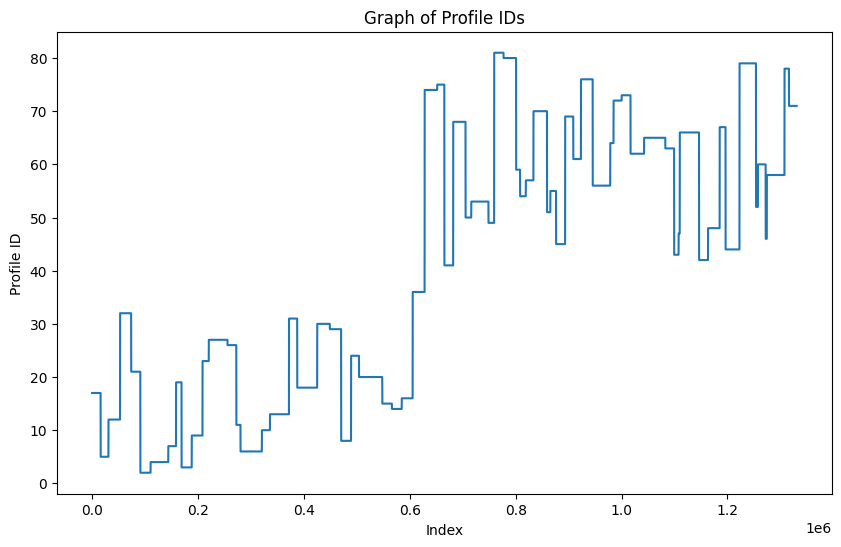

In [53]:
# Let's plot the profile ID values.

plt.figure(figsize=(10, 6))
plt.plot(df['profile_id'])
plt.title('Graph of Profile IDs')
plt.xlabel('Index')
plt.ylabel('Profile ID')
plt.show()

We observe that the profile ID values, which represent the test sessions, don't follow the right session measurements pattern.

In [54]:
#Unique value of the measurement sessions
unique_values = df['profile_id'].unique()
print(unique_values)

[17  5 12 32 21  2  4  7 19  3  9 23 27 26 11  6 10 13 31 18 30 29  8 24
 20 15 14 16 36 74 75 41 68 50 53 49 81 80 59 54 57 70 51 55 45 69 61 76
 56 64 72 73 62 65 63 43 47 66 42 48 67 44 79 52 60 46 58 78 71]


In [55]:
#Sorting the value of the measurement sessions

#The 'mergesort' algorithm is a stable sort, meaning that it maintains the
#relative order of rows with equal 'profile_id' values. However, this code
#creates a new DataFrame sorted_df with the sorted data.
print(df.head(10))
df.sort_values(by='profile_id', kind='mergesort', inplace=True)
unique_values = df['profile_id'].unique()
print(unique_values)

        u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   
5 -0.538973  18.901548       19.077108  0.009147     18.290628     0.009636   
6 -0.653148  18.941711       19.074583  0.238890     18.292524     0.001337   
7 -0.758392  18.960861       19.082499  0.395099     18.294041     0.001422   
8 -0.727128  18.973545       19.085533  0.546623     18.291964     0.000577   
9 -0.874307  18.987812       19.076025  0.578944     18.287233    -0.001248   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19

We notice that some of the "profile_id"s are missing.
This might be a result of certain measurement sections being omitted from the dataset due to measurement errors during the test or for reasons unknown to us.


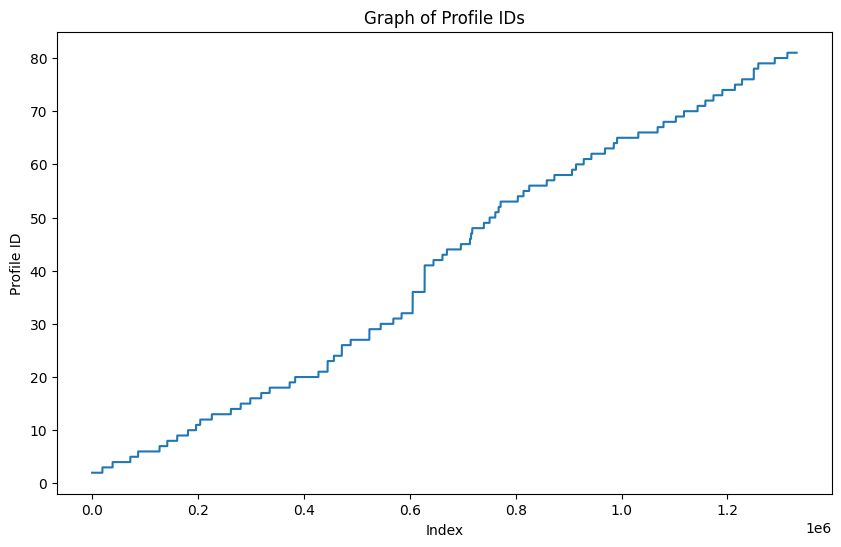

In [56]:
#Correcting the indexes of the sorting dataset
df.reset_index(drop=True, inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(df['profile_id'])
plt.title('Graph of Profile IDs')
plt.xlabel('Index')
plt.ylabel('Profile ID')
plt.show()

The sensors take the data with a frequence of 2 Hz, so every
0.5 secods.
Having to Study a time series, it is better to have for each unique measurement its time line.

In [57]:
# Let's add a column to the dataset, which represents the actual time stamp, starting from 0, of each measurement in each session.

df['time'] = 0.0

previous_profile_id = None

for index, row in df.iterrows():
    if row['profile_id'] != previous_profile_id:
        # Reset increment when profile_id changes
        current_increment = 0.0
        previous_profile_id = row['profile_id']
    df.at[index, 'time'] = current_increment
    current_increment += 0.5

df.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id,time
0,4.921712,15.717488,19.729197,0.051183,18.889385,99.964539,-0.000385,0.000221,23.153740,18.395088,19.995035,-0.605463,2,0.0
1,4.948537,15.890841,19.737572,0.074807,18.895809,100.017822,-0.002003,0.000886,23.153469,18.376493,19.954098,-0.613076,2,0.5
2,4.941477,15.992567,19.740677,0.063648,18.902767,99.999977,0.000156,-0.000046,23.147993,18.371748,19.924765,-0.615070,2,1.0
3,4.921178,16.135164,19.727468,0.076738,18.908100,99.980309,0.001466,-0.001133,23.135658,18.375002,19.903748,-0.617488,2,1.5
4,4.924347,16.165384,19.730543,0.084553,18.876144,100.023392,0.000682,0.003452,23.137959,18.378679,19.888687,-0.606528,2,2.0


## Session Lenghts

Let's see if each measurement test is between the 1 hour and 6 hours as said in the kaggle description.

In [58]:
# First, group by 'profile_id' and find the maximum 'time' for each group
max_times = df.groupby('profile_id')['time'].max() / 3600

# Plot the results
# max_times.plot.barh(figsize=(12,18), grid='both', title='Time per Session')
# plt.xlabel('time (hr)')

import pandas as pd

# Set the display options
pd.set_option('display.max_rows', None)  # This will display an unlimited number of rows
pd.set_option('display.max_columns', None)  # This will display an unlimited number of columns
pd.set_option('display.width', None)  # This will ensure that the display is not truncated horizontally
pd.set_option('display.max_colwidth', None)  # This ensures that the column width is not truncated

# Now when you print a DataFrame or Series, it should display in full
print(max_times)


profile_id
2     2.688333
3     2.673194
4     4.642083
5     2.053750
6     5.609306
7     2.034722
8     2.605000
9     2.824306
10    2.118750
11    1.095278
12    3.047361
13    4.986806
14    2.582917
15    2.517083
16    2.867222
17    2.217083
18    5.240417
19    1.445694
20    6.106944
21    2.405556
23    1.646528
24    2.085278
26    2.314583
27    4.911111
29    2.966250
30    3.314167
31    2.164722
32    2.910972
36    3.140000
41    2.319306
42    2.349861
43    1.172500
44    3.658333
45    2.380694
46    0.302639
47    0.302083
48    3.053056
49    1.502083
50    1.501250
51    0.869444
52    0.517361
53    4.505694
54    1.500833
55    1.500833
56    4.600278
57    2.000278
58    4.636250
59    1.038056
60    2.019722
61    2.015972
62    3.555417
63    2.314861
64    0.867917
65    5.568472
66    5.065972
67    1.546389
68    3.240278
69    2.131806
70    3.566111
71    2.035417
72    2.125000
73    2.331250
74    3.300000
75    1.870972
76    3.081528
78    1.172778

## Correlations

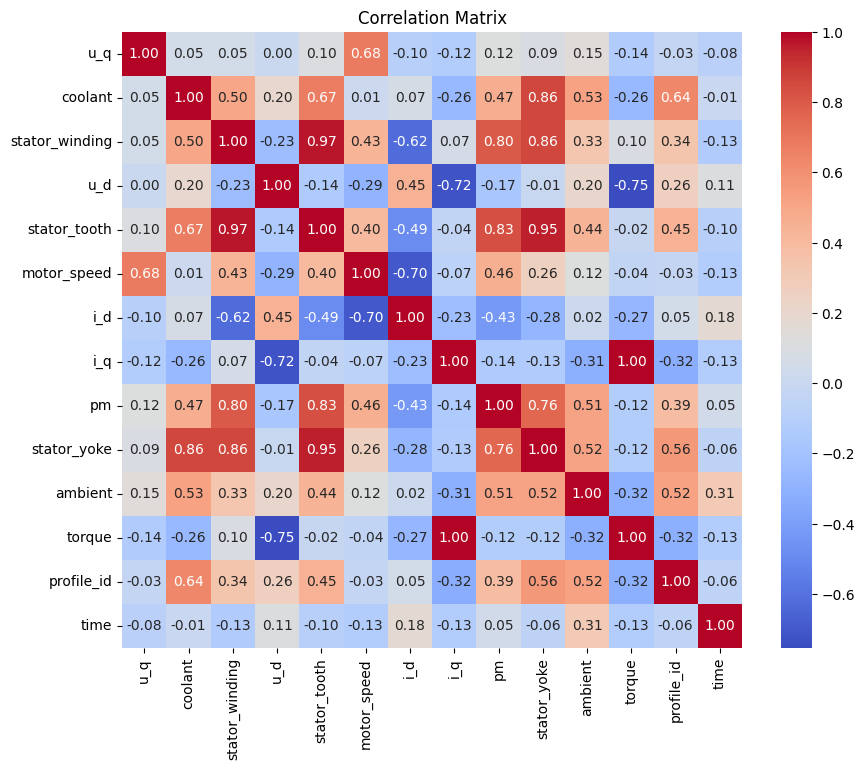

In [59]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix using seaborn's heatmap function
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

From the correlation matrix, various insights are shown:

+ i_q and torque are directly correlated. This is due to the fact that i_q is the current variable which is directly responsable to the torque control in PMSMs.
+ stator_yoke, stator_tooth and stator_winding, all temperatures related to the stator mechanical part, all share a high correlation among them.
+ stator_yoke also shows a high correlation (0.86) with the coolant variable, which is the coolant temperature.


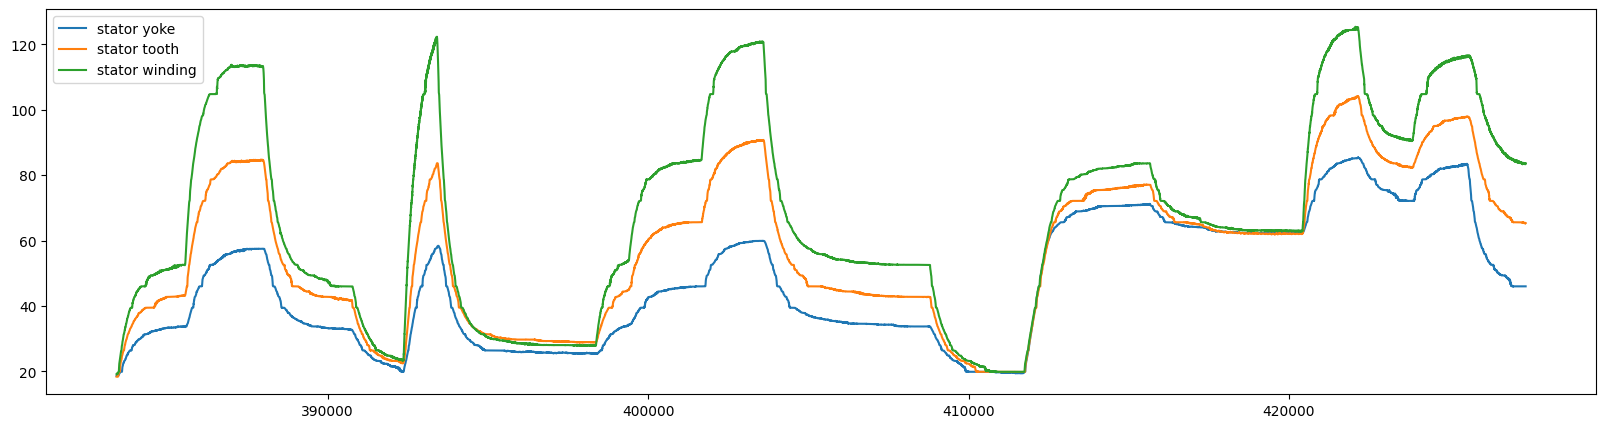

In [60]:
#visualize the correlation between the temperature stator yoke, stator tooth and stator winding
plt.figure(figsize=(20,5))
df[df['profile_id'] == 20]['stator_yoke'].plot(label = 'stator yoke')
df[df['profile_id'] == 20]['stator_tooth'].plot(label = 'stator tooth')
df[df['profile_id'] == 20]['stator_winding'].plot(label = 'stator winding')
plt.legend()

## Plot of interesting variables to visualize the correlation between them.

In [61]:
'''

from itertools import cycle

temp_features = ['coolant', 'stator_tooth', 'stator_yoke', 'stator_winding']  # example features
dfui = df.columns

# Create a color list
color_list = plt.cm.tab10(np.linspace(0, 1, 10))

# Columns of interest
coi = temp_features + [c for c in dfui if c not in temp_features]

# Cycling through the color list
color_cycle = cycle(color_list)

# Creating a dictionary to map features to colors
feat_clrs = {k: rgb2hex(next(color_cycle)[:3]) for k in coi}


coi = temp_features

n_cols = 4
n_rows = np.ceil(len(grpd) / n_cols).astype(int)
fig, axes = plt.subplots(n_rows, n_cols, sharey=True, figsize=(2.8*n_cols, n_rows*3))
for i, (ax, (p_id, df_)) in enumerate(zip(axes.flatten(), grpd.items())):
    for c in coi:
        lines = ax.plot(df_[c].reset_index(drop=True), label=c, color=feat_clrs[c])
    ax.set_title(f'profile {p_id}')
    if i % n_cols == 0:
        ax.set_ylabel('Temp in °C')
    if i >= (len(grpd) - n_cols):
        ax.set_xlabel('Sample')
fig.tight_layout()
_ = ax.legend(ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

'''

"\n\nfrom itertools import cycle\n\ntemp_features = ['coolant', 'stator_tooth', 'stator_yoke', 'stator_winding']  # example features\ndfui = df.columns\n\n# Create a color list\ncolor_list = plt.cm.tab10(np.linspace(0, 1, 10))\n\n# Columns of interest\ncoi = temp_features + [c for c in dfui if c not in temp_features]\n\n# Cycling through the color list\ncolor_cycle = cycle(color_list)\n\n# Creating a dictionary to map features to colors\nfeat_clrs = {k: rgb2hex(next(color_cycle)[:3]) for k in coi}\n\n\ncoi = temp_features\n\nn_cols = 4\nn_rows = np.ceil(len(grpd) / n_cols).astype(int)\nfig, axes = plt.subplots(n_rows, n_cols, sharey=True, figsize=(2.8*n_cols, n_rows*3))\nfor i, (ax, (p_id, df_)) in enumerate(zip(axes.flatten(), grpd.items())):\n    for c in coi:\n        lines = ax.plot(df_[c].reset_index(drop=True), label=c, color=feat_clrs[c])\n    ax.set_title(f'profile {p_id}')\n    if i % n_cols == 0:\n        ax.set_ylabel('Temp in °C')\n    if i >= (len(grpd) - n_cols):\n       

We can now drop the correlated variables.

In [62]:
# Remove the specified columns
df.drop(['stator_tooth', 'coolant', 'stator_winding', 'torque'], axis=1, inplace=True)

In [63]:
# Let's rename the stator_yoke variable to stator_temp
df.rename(columns={'stator_yoke': 'stator_temp'}, inplace=True)

# Check the first few rows to confirm the columns are removed
print(df.head())

        u_q       u_d  motor_speed       i_d       i_q         pm  \
0  4.921712  0.051183    99.964539 -0.000385  0.000221  23.153740   
1  4.948537  0.074807   100.017822 -0.002003  0.000886  23.153469   
2  4.941477  0.063648    99.999977  0.000156 -0.000046  23.147993   
3  4.921178  0.076738    99.980309  0.001466 -0.001133  23.135658   
4  4.924347  0.084553   100.023392  0.000682  0.003452  23.137959   

   stator_temp    ambient  profile_id  time  
0    18.395088  19.995035           2   0.0  
1    18.376493  19.954098           2   0.5  
2    18.371748  19.924765           2   1.0  
3    18.375002  19.903748           2   1.5  
4    18.378679  19.888687           2   2.0  


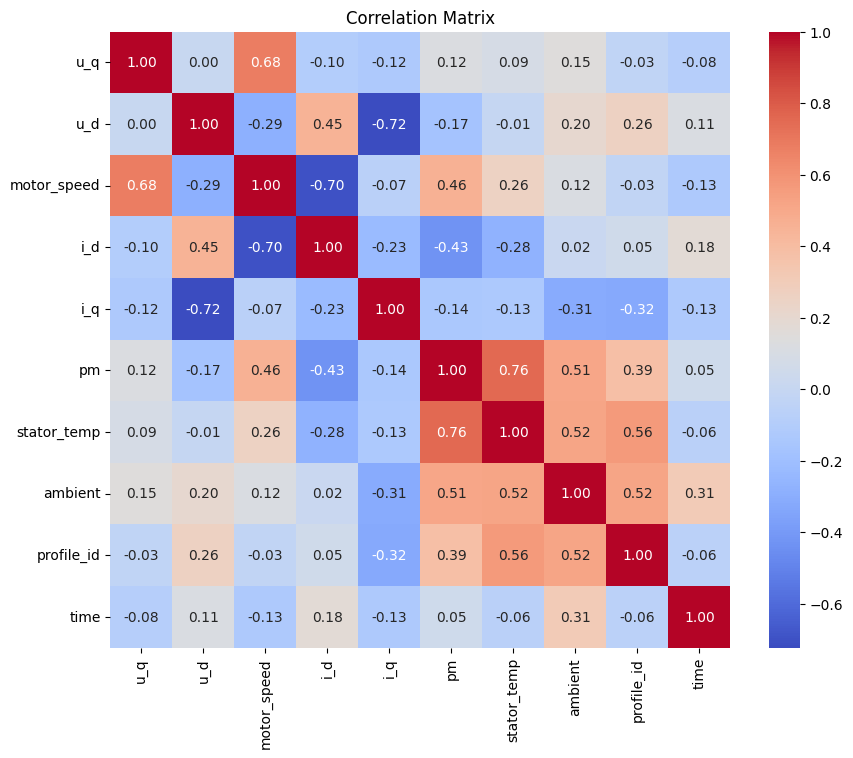

In [64]:
# Re-plot of the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix using seaborn's heatmap function
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

High-correlated values are still present in the dataset, like i_q and u_d, and i_d and motor_speed, but for now we decide to keep them, since the correlation is high but not too much. We also notice a strong correlation between stator_yoke and pm.

## Normalization

Let's normalize the motor_speed variable, since it is the only variable that has a range different from the others.

In [65]:
'''

# Create a MinMaxScaler object with the desired range
scaler = MinMaxScaler(feature_range=(0, 100))

# Reshape (-1, 1) is used because scaler expects 2D array
df['motor_speed_normalized'] = scaler.fit_transform(df[['motor_speed']])

# Check the first few rows to see the normalized values
print(df[['motor_speed', 'motor_speed_normalized']].head())

df.drop(['motor_speed'], axis=1, inplace=True)

'''

"\n\n# Create a MinMaxScaler object with the desired range\nscaler = MinMaxScaler(feature_range=(0, 100))\n\n# Reshape (-1, 1) is used because scaler expects 2D array\ndf['motor_speed_normalized'] = scaler.fit_transform(df[['motor_speed']])\n\n# Check the first few rows to see the normalized values\nprint(df[['motor_speed', 'motor_speed_normalized']].head())\n\ndf.drop(['motor_speed'], axis=1, inplace=True)\n\n"

In [66]:
# Group the data by 'profile_id'
grouped = df.groupby('profile_id')

# Initialize a dictionary to store statistics for each profile_id and each feature
profile_stats = {}

# Calculate statistics for each profile_id and each feature
for profile_id, group_data in grouped:
    feature_stats = {}

    for feature in df.columns:
        if feature not in ['profile_id', 'time']:
            mean_value = group_data[feature].mean()

            feature_stats[f'Mean {feature}'] = mean_value


    # Store the statistics in the dictionary
    profile_stats[profile_id] = feature_stats

# Convert the dictionary to a DataFrame for easier analysis and visualization
profile_stats_df = pd.DataFrame.from_dict(profile_stats, orient='index')

# Print or analyze the statistics as needed
print(profile_stats_df)

      Mean u_q   Mean u_d  Mean motor_speed    Mean i_d    Mean i_q  \
2     5.894508  -2.815422        100.000216  -48.212822   93.315905   
3     5.918387  -1.958329         99.996061  -22.684171   66.636316   
4    76.794853 -38.563626       2683.072902  -52.435694   40.571468   
5    47.176984 -18.290178        999.990768  -19.476087   56.473858   
6    63.622428 -41.895906       3445.307672 -101.816880   16.833996   
7    23.812275 -18.022538        499.589026  -36.086202  109.100633   
8    68.059763 -33.494845       1498.038632  -23.550349   69.380513   
9   100.513499 -56.173517       2496.962762  -43.065578   69.297586   
10   55.367238  -7.700773       1926.081570  -43.033984   -5.194602   
11   58.909082 -47.349078       2115.516636  -63.531149   57.653508   
12   88.937285 -49.668858       1998.111381  -26.100498   77.459100   
13   12.932442  -5.827154        249.886363  -24.200211   71.436321   
14   94.494970 -67.822014       2997.064568  -81.446060   68.551160   
15   6

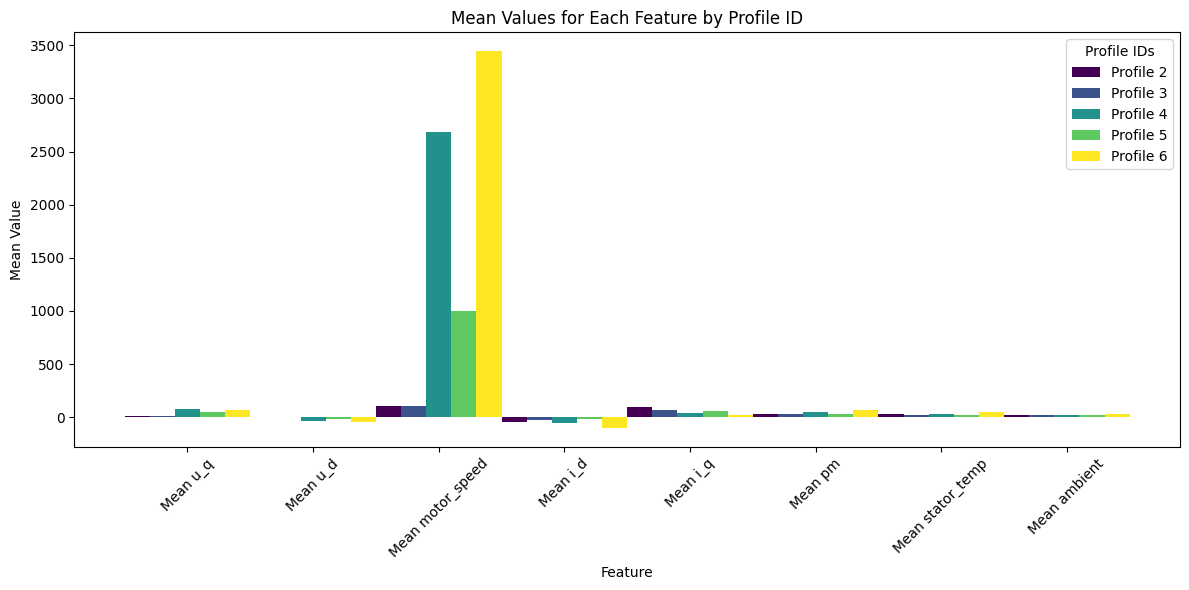

In [67]:
# Transpose the DataFrame for better visualization
profile_stats_df = profile_stats_df.T

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the mean values for each feature
num_profiles_to_plot = 5  # Adjust the number of profiles to plot as needed
colors = plt.cm.viridis(np.linspace(0, 1, num_profiles_to_plot))  # Choose a color map
profile_ids_to_plot = profile_stats_df.columns[:num_profiles_to_plot]

for i, profile_id in enumerate(profile_ids_to_plot):
    plt.bar(
        np.arange(len(profile_stats_df.index)) + i * 0.2,
        profile_stats_df[profile_id],
        width=0.2,
        label=f'Profile {profile_id}',
        color=colors[i]
    )

# Add labels and title
plt.xlabel('Feature')
plt.ylabel('Mean Value')
plt.title('Mean Values for Each Feature by Profile ID')

# Set x-axis labels and adjust rotation if needed
plt.xticks(np.arange(len(profile_stats_df.index)) + 0.2 * (num_profiles_to_plot - 1) / 2, profile_stats_df.index, rotation=45)

# Create a simplified legend
plt.legend(loc='upper right', title='Profile IDs')

# Show the plot
plt.tight_layout()
plt.show()

**Dropping the time feature.**

In [68]:
df.drop(['time'], axis=1, inplace=True)